# Inference
In this notebook we load the pre-trained models, generate or upload some structures, and predict their defect formation energy per site and HOMO-LUMO gap. For magnetic structures, the models predict the minimum of spin-up and spin-down HOMO-LUMO gaps.

# Initialization
If we are on Constructor Research Platform (CRP), limit us to the CPUs available there

In [1]:
import os
if 'ROLOS_AVAILABLE_CPU' in os.environ:
    for variable in ("MKL_NUM_THREADS", "NUMEXPR_NUM_THREADS", "OMP_NUM_THREADS", "VECLIB_MAXIMUM_THREADS", "OPENBLAS_NUM_THREADS"):
        os.environ[variable] = os.environ['ROLOS_AVAILABLE_CPU']
    import torch
    torch.set_num_threads(int(os.environ['ROLOS_AVAILABLE_CPU']))

In [2]:
%matplotlib widget
from pathlib import Path
import pickle
import yaml
import sys
import zipfile
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
from pymatgen.core.structure import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.cif import CifParser

import matplotlib
import ipywidgets as widgets
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
from collections import defaultdict
import io

sys.path.append("..")
from ai4mat.models.megnet_pytorch.megnet_on_structures import MEGNetOnStructures
from ai4mat.data.data import get_unit_cell, StorageResolver, read_defects_descriptions
from ai4mat.common.sparse_representation import get_sparse_defect, SINGLE_ENENRGY_COLUMN
from ai4mat.common.random_defect_generation import generate_structure_with_random_defects, InconsistentDefectCount
from ai4mat.common.eos import EOS

Load the models

In [3]:
training_experiment = "combined_mixed_all_train"
model_names = {
    "formation_energy_per_site": "megnet_pytorch/sparse/05-12-2022_19-50-53/d6b7ce45",
    "homo_lumo_gap_min": "megnet_pytorch/sparse/05-12-2022_19-50-53/831cc496"}

predictors = dict()
for target, trial_name in model_names.items():
    with open(StorageResolver()["trials"] / f"{trial_name}.yaml", "r") as f:
        config = yaml.safe_load(f)
    predictors[target] = MEGNetOnStructures(config['model_params'])
    predictors[target].load(StorageResolver()["checkpoints"] / training_experiment / target / trial_name / "0.pth",
                            map_location='cpu')

Read the parameters of the experiment that the models were trained on. From them we find out which base materials and point defect types were present in the training set.

In [4]:
experiment_path = StorageResolver()["experiments"].joinpath(training_experiment)
with open(Path(experiment_path, "config.yaml")) as experiment_file:
    experiment_config = yaml.safe_load(experiment_file)
# We don't check how the data are split inside the experiment
# It's the user's responsibility to ensure that the model works on all datasets mentioned
training_datasets = experiment_config["datasets"]

# Computing EOS takes around a minute, so we use the cache
inference_unit_cells_file = StorageResolver()["others"] / "inference_unit_cells_cache.pkl.gz"
unit_cells_loaded = False
try:
    with open(inference_unit_cells_file, 'rb') as f:
        unit_cells, unit_cells_EOS = pickle.load(f)
    unit_cells_loaded = True
    print("Loaded unit cells from cache")
except Exception as inst:
    print(inst)
    print("Can't load unit cells from cache, generating them")
    unit_cells_EOS = dict()
    unit_cells = dict()

defects_list = []
for dataset in tqdm(training_datasets):
    defects = read_defects_descriptions(StorageResolver()["csv_cif"] / dataset)
    materials = defects.base.unique()
    assert len(materials) == 1
    material = materials[0]
    cell = defects.cell.unique()
    assert len(cell) == 1
    cell = cell[0]
    # We have two MoS2/WSe2 unit cells with slightly different height,
    # both are valid and there is no need to include them here
    if not unit_cells_loaded:
        unit_cells[material] = get_unit_cell(StorageResolver()["csv_cif"] / dataset, materials)[material]
        unit_cells_EOS[material] = EOS().get_augmented_struct(unit_cells[material])
    defects_list.append(defects)
if not unit_cells_loaded:
    with open(inference_unit_cells_file, 'wb') as f:
        pickle.dump((unit_cells, unit_cells_EOS), f)
defects_pd = pd.concat(defects_list, axis=0)
if 'pbc' in defects_pd.columns:
    defects_pd = defects_pd.drop(columns=['pbc'])

Loaded unit cells from cache


  0%|          | 0/8 [00:00<?, ?it/s]

With some hashable magic, we get the set of all point defects for each base material

In [5]:
from itertools import chain
from collections import namedtuple
SubstitutionDefect = namedtuple('substitution_defect', ['type', 'from_', 'to'])
VacancyDefect = namedtuple('vacancy_defect', ['type', 'element'])
def to_named_tuple(dict_):
    if dict_['type'] == 'substitution':
        return SubstitutionDefect(dict_['type'], dict_['from'], dict_['to'])
    elif dict_['type'] == 'vacancy':
        return VacancyDefect(**dict_)
    else:
        raise ValueError(f"Unknown defect type {dict_['type']}")
available_defects = defects_pd.groupby(['base', 'cell']).apply(lambda x: set(map(to_named_tuple, chain(*x.defects))))

# Two options for data acquisition

## Option 1: generate the structures

A lot of code for creating the structure generation interface

In [6]:
reference_supercells = dict()
for material in available_defects.index:
    reference_supercells[material] = unit_cells[material[0]].copy()
    reference_supercells[material].make_supercell(material[1])

In [7]:
material_labels = list(map(lambda x: f"{x[0]}, {x[1][0]}x{x[1][1]} supercell", available_defects.index))

In [8]:
def get_label(defect_tuple):
    if defect_tuple.type == 'substitution':
        return f"{defect_tuple.from_} -> {defect_tuple.to}"
    elif defect_tuple.type == 'vacancy':
        return f"{defect_tuple.element} vacancy"
    else:
        raise ValueError(f"Unknown defect type {defect_tuple.type}")

In [9]:
base_selection = widgets.RadioButtons(options=zip(material_labels, available_defects.index), description='Base material')
total_structures_selection = widgets.IntSlider(min=1, max=100, step=1, value=100)
total_defects_selection = widgets.IntSlider(min=0, max=15, step=1, value=1)
max_defect_counts_selection = dict()

structure_plots_output = widgets.Output()
rng = np.random.default_rng(42)
image_widget = widgets.Image(format='png', width=700, height=300,
                             layout=widgets.Layout(object_fit='contain'))

reference_atoms = dict()
for material, supercell in reference_supercells.items():
    reference_atoms[material] = AseAtomsAdaptor.get_atoms(supercell)

def read_max_defect_counts_selection():
    """
    Reads the widget and returns a dict with max defect counts for each defect type
    suitable for the generate_structure_with_random_defects function
    """
    max_defect_counts = defaultdict(dict)
    for defect, count_widget in max_defect_counts_selection.items():
        if defect.type == 'substitution':
            max_defect_counts[defect.from_][defect.to] = count_widget.value
        else:
            max_defect_counts[defect.element]["Vacancy"] = count_widget.value
    return max_defect_counts

def plot_structures():
    base_material = base_selection.value
    max_defect_counts = read_max_defect_counts_selection()
    backend = matplotlib.get_backend()
    try:
        matplotlib.use('agg')
        fig, axes = plt.subplots(1, 2, figsize=(7, 3), dpi=300, layout="constrained")
        try:
            example_defect = generate_structure_with_random_defects(total_defects_selection.value, max_defect_counts,
                                                                    reference_supercells[base_material], rng, False)
            atoms = AseAtomsAdaptor.get_atoms(example_defect)
            plot_atoms(atoms, ax=axes[1])
        except InconsistentDefectCount:
            axes[1].text(0.5, 0.5,
                    "Can't generate the requested number of defects,\nincrease the max counts",
                    horizontalalignment='center', verticalalignment='center')
        
        plot_atoms(reference_atoms[base_material], ax=axes[0])
        axes[0].set_title("Pristine structure")
        axes[1].set_title("Example structure with defects")
        for ax in axes:
            ax.set_axis_off()
        img_buf = io.BytesIO()
        fig.savefig(img_buf, format='png')
        plt.close(fig)
        image_widget.value = img_buf.getvalue()
    finally:
        matplotlib.use(backend)

def prepare_defect_sliders(base_material):
    max_defect_counts_selection.clear()
    for defect in available_defects[base_material]:
        max_defect_counts_selection[defect] = widgets.IntSlider(min=0, max=15, step=1, value=1, description=get_label(defect))
        max_defect_counts_selection[defect].observe(plot_structures_watcher)

    controls.children = [base_selection,
                         widgets.Label("Max counts for each defect type:"),
                         *max_defect_counts_selection.values(),
                         widgets.Label("Total defects:"),
                         total_defects_selection,
                         widgets.Label("Total structures to generate:"),
                         total_structures_selection]
    plot_structures()

def select_defects(change):
    if change['type'] == 'change' and change['name'] == 'value':
        prepare_defect_sliders(change['owner'].value)

def plot_structures_watcher(change):
    if change['type'] == 'change' and change['name'] == 'value':
        plot_structures()

base_selection.observe(select_defects)

controls = widgets.VBox([base_selection])
interface = widgets.HBox([controls, image_widget])
prepare_defect_sliders(base_selection.value)
total_defects_selection.observe(plot_structures_watcher)
display(interface)

Above you should see widgets allowing you to specify the defects to generate. Once you are happy with the generation options, continue with notebook. If you don't see the widgets, you probably have a problem with [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) and can specify the parameters below by hand:

In [10]:
base_material = base_selection.value
# material = ('MoS2', (8, 8, 1))
# material should be a tuple of (formula, supercell_size) from available_defects.index
# The models don't generalise to chemically different materials
# Generalising to different supercell sizes is possible but not well tested
if material not in available_defects.index:
    raise ValueError(f"Unknown material {material}, use one in \n{available_defects.index}")

# The number of point defects your structures will have
total_defects = total_defects_selection.value
# total_defects = 3

# The maximum number of each defect type your structures will have
max_defect_counts = read_max_defect_counts_selection()
# max_defect_counts = {'S': {'Se': 1, 'Vacancy': 1}, 'Mo': {'Vacancy': 1, 'W': 1}}

# The number of structures to generate
total_structures = total_structures_selection.value
# total_structures = 100

In [11]:
reference_supercell = reference_supercells[base_material]
structures = []
for i in trange(total_structures):
    structures.append(generate_structure_with_random_defects(total_defects, max_defect_counts,
                                                             reference_supercell, rng, False))

  0%|          | 0/100 [00:00<?, ?it/s]

## Option 2: upload
Upload your own structures for the model to predict. Note that for the predictions to make sense, the base materials and point defect types must be present in the training dataset.
1. Unit cell in `.cif` format. [Example](../datasets/others/upload_example/MoS2.cif)
2. Structures as a `.zip` archive with `.cif` structures inside. [Example](../datasets/others/upload_example/structures.zip)
3. Supercell size in unit cells: self-explanatory, but don't forget. Use 1x1 if your unit cell is in fact a supercell
4. Push the button

**It's safe to run this code if you generated the structures, it won't do anything without pressing the button**

In [ ]:
# unit_cell_uploader = widgets.FileUpload(accept='.cif', multiple=False, description="Unit cell .cif")
# structures_uploader = widgets.FileUpload(accept='.zip', multiple=False, description="Structures")
# The widgets crash CRP (as of 22.06.2023)
# https://mm.rolos.dev/rolos-team/pl/nod5setpjibb7chnfqqim93h7a

# Upload the files using the interface and specify the paths here
unit_cell_path = "../datasets/others/upload_example/MoS2.cif"
structures_path = "../datasets/others/upload_example/structures.zip"
unit_cell_uploader = widgets.Label(f"[Edit the cell to change] Unit cell: {unit_cell_path}")
structures_uploader = widgets.Label(f"[Edit the cell to change] Structures: {structures_path}")

supercell_selector_style = {'description_width': 'initial'}
supercell_x = widgets.BoundedIntText(description="Supercell size in unit cells:", value=8, min=1,
                                     layout=widgets.Layout(width='200px'), style=supercell_selector_style)
supercell_y = widgets.BoundedIntText(description="x", value=8, min=1,
                                     layout=widgets.Layout(width='50px'), style=supercell_selector_style)
process_upload_button = widgets.Button(description="Process upload")
upload_interface = widgets.HBox([supercell_x, supercell_y, process_upload_button])
def process_upload(button):
    print("Loading the data...")
    unit_cell = Structure.from_file(unit_cell_path)
    uploaded_material = (unit_cell.formula, (supercell_x.value, supercell_y.value, 1))
    reference_supercell = unit_cell.copy()
    reference_supercell.make_supercell(uploaded_material[1])
    global structures
    structures = []
    with zipfile.ZipFile(structures_path, "r") as structures_arhive:
        for name in structures_arhive.namelist():
            cif_data = structures_arhive.read(name).decode("ascii")
            this_structure_file = CifParser.from_string(cif_data)
            new_structures = this_structure_file.get_structures(primitive=False)
            for structure in new_structures:
                if not np.allclose(structure.lattice.matrix, reference_supercell.lattice.matrix):
                    raise ValueError("Structure and reference supercell have different lattices")
                structures.append(structure)
    global base_material
    base_material = uploaded_material
    global total_defects
    total_defects = None
    global max_defect_counts
    max_defect_counts = None
    global total_structures
    total_structures = len(structures)
    unit_cells_EOS[base_material[0]] = EOS().get_augmented_struct(unit_cell)
    print(f"Loaded {len(structures)} structures of {uploaded_material[1][0]}x{uploaded_material[1][1]} {uploaded_material[0]}")
process_upload_button.on_click(process_upload)
display(unit_cell_uploader, structures_uploader, upload_interface)

# Prepare and plot the sparse structures

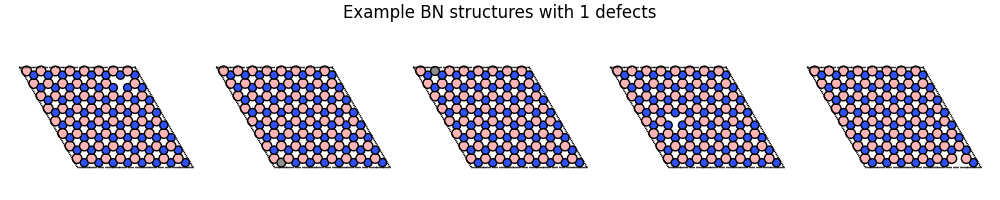

In [12]:
if total_defects is not None:
    total_defects_label = str(total_defects) + " "
else:
    total_defects_label = ""
defects_to_plot = min(5, len(structures))
fig, axes = plt.subplots(1, defects_to_plot, figsize=(defects_to_plot * 2, 2),
                         layout="tight")
for i in range(defects_to_plot):
    atoms = AseAtomsAdaptor.get_atoms(structures[i])
    plot_atoms(atoms, ax=axes[i])
    axes[i].set_axis_off()
fig.suptitle(f"Example {base_material[0]} structures with {total_defects_label}defects")
fig.canvas.header_visible = False

  0%|          | 0/100 [00:00<?, ?it/s]

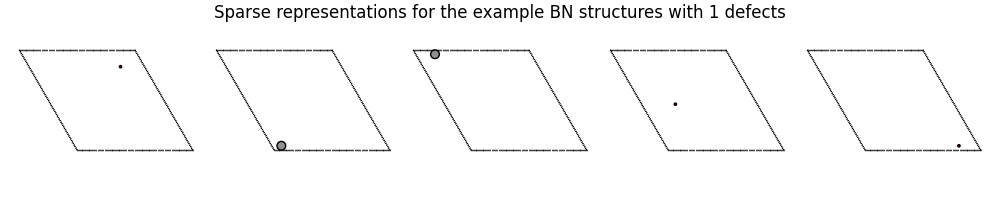

In [13]:
class DummyDataFrame():
    """
    A class that mimics a pandas dataframe of zeros
    """
    class DummyIndexer():
        def __getitem__(self, *args, **kwargs):
            return 0
    @property
    def loc(self, *args, **kwargs):
        return self.DummyIndexer()

# Prepare dummy single atom energies
# They don't affect the sparse representations of structures.
# Their role is to transform the total potential energy of the structure
# formation energy of the defects. Our models are
# trained to predict directly the formation energy per site
single_atom_energies_dummy = DummyDataFrame()

# Compute the sparse representations
sparse_structures = []
for structure in tqdm(structures):
    sparse_structures.append(get_sparse_defect(structure, unit_cells_EOS[base_material[0]], base_material[1], single_atom_energies_dummy)[0])
# Plot
fig, axes = plt.subplots(1, defects_to_plot, figsize=(defects_to_plot * 2, 2))
for i in range(defects_to_plot):
    atoms = AseAtomsAdaptor.get_atoms(sparse_structures[i])
    plot_atoms(atoms, ax=axes[i])
    axes[i].set_axis_off()
fig.tight_layout()
fig.suptitle(f"Sparse representations for the example {base_material[0]} structures with {total_defects_label}defects")
fig.canvas.header_visible = False

Here is a sparse structure in the text format

In [14]:
sparse_structures[0]

Structure Summary
Lattice
    abc : 20.09942768 20.099427679999998 20.0
 angles : 90.0 90.0 120.00001201
 volume : 6997.259129016822
      A : 20.09942768 0.0 1.2307349886502857e-15
      B : -10.04971748867072 17.40661286584659 1.2307349886502857e-15
      C : 0.0 0.0 20.0
    pbc : True True True
PeriodicSite: X0+ (7.5473, 14.4997, 3.8600) [0.7920, 0.8330, 0.1930]

# Predict

In [15]:
predictions = pd.DataFrame(columns=["structure", "sparse_structure"] + list(predictors.keys()))
predictions["structure"] = structures
predictions["sparse_structure"] = sparse_structures
for target, predictor in predictors.items():
    predictions[target] = predictor.predict_structures(sparse_structures)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# Analyze predictions

Let's explore our predictions!

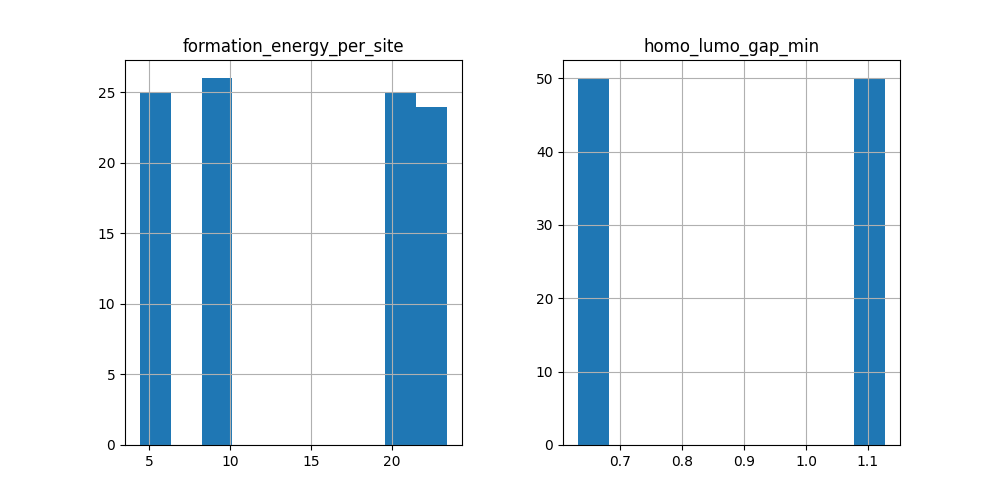

In [16]:
# Both formation energy per site and HOMO-LUMO gap are in eV
predictions.hist(figsize=(10, 5), bins=10);

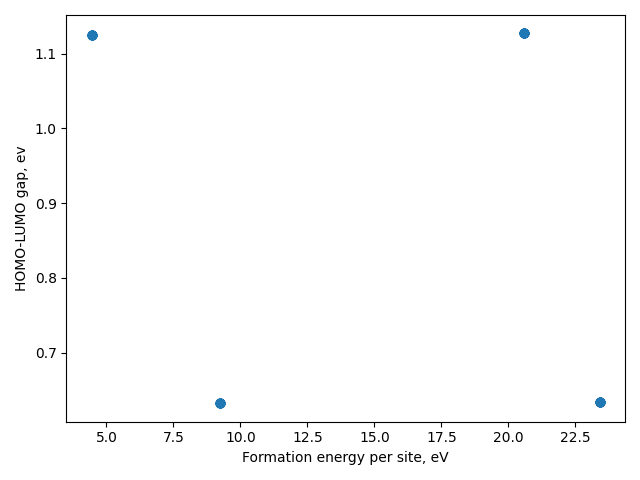

In [17]:
fig, ax = plt.subplots(layout="tight")
ax.scatter(predictions["formation_energy_per_site"], predictions["homo_lumo_gap_min"])
ax.set_xlabel("Formation energy per site, eV")
ax.set_ylabel("HOMO-LUMO gap, ev");
fig.canvas.header_visible = False

Find and plot structures across the property range

In [18]:
structures_to_plot = 5
fig = plt.figure(figsize=(structures_to_plot*2, len(predictors.keys())*2), layout="constrained")
subfigs = fig.subfigures(nrows=len(predictors.keys()), ncols=1)

for target, subfig in zip(predictors.keys(), subfigs):
    sorted_predictions = predictions.sort_values(target, ignore_index=True)
    values_to_plot = np.linspace(sorted_predictions[target].iloc[0], sorted_predictions[target].iloc[-1], num=structures_to_plot)
    indices_to_plot = np.searchsorted(sorted_predictions[target], values_to_plot)
    subfig.suptitle(target)
    axes = subfig.subplots(nrows=1, ncols=len(indices_to_plot))
    for index, ax in zip(indices_to_plot, axes):
        plot_atoms(AseAtomsAdaptor.get_atoms(sorted_predictions.loc[index, "structure"]), ax=ax)
        ax.set_axis_off()
        ax.set_title(f"{sorted_predictions.loc[index, target]:.3f} eV")
fig.canvas.header_visible = False

## Upload to Data catalog

In [ ]:
from typing import List
import uuid
try:
    from rolos_sdk import Dataframe, DataStorageInterface, DataStorageType, TableColumn
    from rolos_sdk.structures.object.pymatgen import PyMatGenObject

    def upload_data(table_data: List[List], table_schema: List[TableColumn], name: str) -> None:
        with DataStorageInterface.create(DataStorageType.Datacat) as storage:
            with Dataframe(name=name, storage=storage, schema=table_schema) as frame:
                frame.insert(table_data)

    schema = [TableColumn(name="structure", type=PyMatGenObject),
              TableColumn(name="sparse_structure", type=PyMatGenObject)] + \
             [TableColumn(name=target, type=float) for target in predictors.keys()]
    dataset_name = f"Predicted {base_material[0]} structures with {total_defects_label}defects {uuid.uuid4()}"
    upload_data(predictions.values.tolist(), schema, dataset_name)
    print(f'Uploaded "{dataset_name}"')
except ImportError:
    print("Can't import the SDK, most likely because you are not running on CRP")